In [35]:
import cv2
import numpy as np
from ultralytics import YOLO
from scipy.optimize import linear_sum_assignment
import os
import json

os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

class KalmanFilterManual:
    def __init__(self, x, y):
        self.state = np.array([x, y, 0, 0], dtype='float64')  # [x, y, vx, vy]
        self.P = np.eye(4) * 1000
        self.F = np.array([[1, 0, 1, 0],
                           [0, 1, 0, 1],
                           [0, 0, 1, 0],
                           [0, 0, 0, 1]])
        self.H = np.array([[1, 0, 0, 0],
                           [0, 1, 0, 0]])
        self.R = np.eye(2) * 10
        self.I = np.eye(4)
        self.Q = np.eye(4)

    def predict(self):
        self.state = np.dot(self.F, self.state)
        self.P = np.dot(np.dot(self.F, self.P), self.F.T) + self.Q

    def update(self, z):
        y = z - np.dot(self.H, self.state)
        S = np.dot(np.dot(self.H, self.P), self.H.T) + self.R
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))
        self.state += np.dot(K, y)
        self.P = np.dot(self.I - np.dot(K, self.H), self.P)

    def get_state(self):
        return self.state[:2]

class SpeedBasedFallDetector:
    def __init__(self, threshold=20):
        self.previous_positions = {}
        self.threshold = threshold

    def detect_fall(self, keypoints, track_id):
        try:
            head = keypoints[0, :2]
            if track_id in self.previous_positions:
                previous_head = self.previous_positions[track_id]
                movement_vector = head - previous_head
                speed = np.linalg.norm(movement_vector)
                direction = np.arctan2(movement_vector[1], movement_vector[0])  # Calculate direction in radians
                
                self.previous_positions[track_id] = head
                
                # Example: Check if movement is towards the bottom right
                if speed > self.threshold and (np.pi/4 <= direction <= 3*np.pi/4):  # Adjust angle range as needed
                    return True
            else:
                self.previous_positions[track_id] = head
        except IndexError:
            return False
        return False


def save_keypoints_data(file_path, data):
    with open(file_path, 'w') as f:
        json.dump(data, f)

# Load YOLO model
yolo_model = YOLO('yolov8n-pose.pt')

# Initialize video capture
cap = cv2.VideoCapture('dummy.mp4')
if not cap.isOpened():
    print("Error: Could not open video capture.")
    exit()

# Tracking state
tracks = []
next_id = 0
trackers = {}
frame_data = {'fall': [], 'non_fall': []}  # New dictionary to store frame data

# Initialize fall detector
fall_detector = SpeedBasedFallDetector(threshold=20)

# Initialize video writer
output_video_path = 'output_video.avi'
fourcc = cv2.VideoWriter_fourcc(*'XVID')
output_video = cv2.VideoWriter(output_video_path, fourcc, 20.0, (int(cap.get(3)), int(cap.get(4))))

frame_count = 0

# Main loop for real-time processing
while True:
    ret, frame = cap.read()
    if not ret:
        break

    results = yolo_model(frame)

    detections = []
    for result in results:
        keypoints = result.keypoints.data
        boxes = result.boxes.data
        for i in range(len(boxes)):
            x_min, y_min, x_max, y_max, confidence, _ = boxes[i].tolist()
            center_x = (x_min + x_max) / 2
            center_y = (y_min + y_max) / 2
            detections.append((center_x, center_y, keypoints[i], boxes[i]))

    # Predict new positions of existing tracks
    for tracker in trackers.values():
        tracker.predict()

    # Match detections to tracks using a distance threshold
    if len(tracks) > 0 and len(detections) > 0:
        track_states = np.array([tracker.get_state() for tracker in trackers.values()])
        detection_centers = np.array([[det[0], det[1]] for det in detections])
        cost_matrix = np.linalg.norm(track_states[:, np.newaxis] - detection_centers, axis=2)
        row_indices, col_indices = linear_sum_assignment(cost_matrix)

        unmatched_tracks = set(tracks)
        unmatched_detections = set(range(len(detections)))

        for row, col in zip(row_indices, col_indices):
            if cost_matrix[row, col] < 50:  # Distance threshold
                trackers[tracks[row]].update(np.array([detections[col][0], detections[col][1]]))
                unmatched_tracks.remove(tracks[row])
                unmatched_detections.remove(col)
    else:
        unmatched_tracks = set(tracks)
        unmatched_detections = set(range(len(detections)))

    # Create new tracks for unmatched detections
    for detection_idx in unmatched_detections:
        new_track_id = next_id
        next_id += 1
        trackers[new_track_id] = KalmanFilterManual(detections[detection_idx][0], detections[detection_idx][1])
        tracks.append(new_track_id)

    # Remove old tracks (not shown in video)
    tracks_to_remove = [track_id for track_id in unmatched_tracks if trackers[track_id].state[2] < -30]
    for track_id in tracks_to_remove:
        del trackers[track_id]
        tracks.remove(track_id)

    # Display results
    for track_id in tracks:
        tracker = trackers[track_id]
        bbox = tracker.get_state()
        for detection in detections:
            detection_center = np.array([detection[0], detection[1]])
            if np.linalg.norm(bbox - detection_center) < 50:  # Association threshold
                keypoints = detection[2][:, :2].flatten()  # Only take x and y coordinates
                fall_detected = fall_detector.detect_fall(detection[2], track_id)
                if fall_detected:
                    print(f"Fall detected for track ID {track_id}!")
                    frame_data['fall'].append({'frame': frame_count, 'keypoints': keypoints.tolist()})
                    box_color = (0, 0, 255)
                else:
                    frame_data['non_fall'].append({'frame': frame_count, 'keypoints': keypoints.tolist()})
                    box_color = (255, 0, 0)

                x_min, y_min, x_max, y_max, confidence, _ = detection[3].tolist()
                # Draw bounding box
                cv2.rectangle(frame, (int(x_min), int(y_min)), (int(x_max), int(y_max)), box_color, 2)
                cv2.putText(frame, f'ID: {track_id}', (int(x_min), int(y_min) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, box_color, 2)

                # Display subset of key points with lines
                keypoints = detection[2]
                keypoints_to_display = keypoints[[0, 9, 10, 15, 16]]  # Selecting head, body, and leg keypoints
                for i in range(len(keypoints_to_display)):
                    x, y = int(keypoints_to_display[i][0]), int(keypoints_to_display[i][1])
                    cv2.circle(frame, (x, y), 5, (0, 255, 0), -1)  # Display key points

    # Write frame to output video
    output_video.write(frame)

    # Save keypoints data periodically or at the end of processing
    save_keypoints_data('keypoints_data.json', frame_data)

    frame_count += 1  # Increment frame count

    cv2.imshow('Real-Time Fall Detection', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release video capture, writer, and close all windows
cap.release()
output_video.release()
cv2.destroyAllWindows()


0: 640x384 1 person, 378.6ms
Speed: 69.8ms preprocess, 378.6ms inference, 65.6ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 475.4ms
Speed: 42.6ms preprocess, 475.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 217.4ms
Speed: 10.4ms preprocess, 217.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 235.9ms
Speed: 4.8ms preprocess, 235.9ms inference, 4.7ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 239.1ms
Speed: 6.4ms preprocess, 239.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 219.3ms
Speed: 2.9ms preprocess, 219.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 209.6ms
Speed: 2.7ms preprocess, 209.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 218.4ms
Speed: 11.0ms preprocess, 218.4ms inference, 1.0ms postprocess per ima

Fall detected for track ID 0!


0: 640x384 1 person, 165.9ms
Speed: 7.7ms preprocess, 165.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 238.3ms
Speed: 4.9ms preprocess, 238.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 171.9ms
Speed: 2.6ms preprocess, 171.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 190.1ms
Speed: 5.7ms preprocess, 190.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 195.6ms
Speed: 2.3ms preprocess, 195.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 248.6ms
Speed: 3.5ms preprocess, 248.6ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 437.5ms
Speed: 49.8ms preprocess, 437.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 179.3ms
Speed: 7.1ms preprocess, 179.3ms inference, 1.0ms postprocess per image at

Fall detected for track ID 0!


0: 640x384 1 person, 183.6ms
Speed: 3.1ms preprocess, 183.6ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 186.9ms
Speed: 2.6ms preprocess, 186.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



Fall detected for track ID 0!


0: 640x384 1 person, 172.5ms
Speed: 7.1ms preprocess, 172.5ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 201.0ms
Speed: 6.5ms preprocess, 201.0ms inference, 4.9ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 195.8ms
Speed: 4.9ms preprocess, 195.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 164.7ms
Speed: 7.8ms preprocess, 164.7ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 173.1ms
Speed: 4.2ms preprocess, 173.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 161.3ms


Fall detected for track ID 0!


Speed: 2.4ms preprocess, 161.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 242.0ms
Speed: 6.4ms preprocess, 242.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)



Fall detected for track ID 0!


0: 640x384 1 person, 451.4ms
Speed: 36.2ms preprocess, 451.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 205.1ms
Speed: 8.9ms preprocess, 205.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 193.4ms
Speed: 3.1ms preprocess, 193.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 186.7ms
Speed: 2.5ms preprocess, 186.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)



Fall detected for track ID 0!


0: 640x384 1 person, 220.8ms
Speed: 3.2ms preprocess, 220.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 164.6ms


Fall detected for track ID 0!


Speed: 2.6ms preprocess, 164.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 200.0ms
Speed: 5.2ms preprocess, 200.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 149.7ms
Speed: 2.5ms preprocess, 149.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



Fall detected for track ID 0!


0: 640x384 1 person, 180.7ms
Speed: 5.7ms preprocess, 180.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 176.5ms
Speed: 7.5ms preprocess, 176.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



Fall detected for track ID 0!


0: 640x384 1 person, 176.2ms
Speed: 5.2ms preprocess, 176.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 442.6ms
Speed: 49.5ms preprocess, 442.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 179.6ms
Speed: 6.5ms preprocess, 179.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 163.0ms
Speed: 4.1ms preprocess, 163.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 161.2ms
Speed: 3.4ms preprocess, 161.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 164.2ms
Speed: 6.3ms preprocess, 164.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 184.3ms
Speed: 4.7ms preprocess, 184.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 187.0ms
Speed: 3.3ms preprocess, 187.0ms inference, 1.0ms postprocess per image at

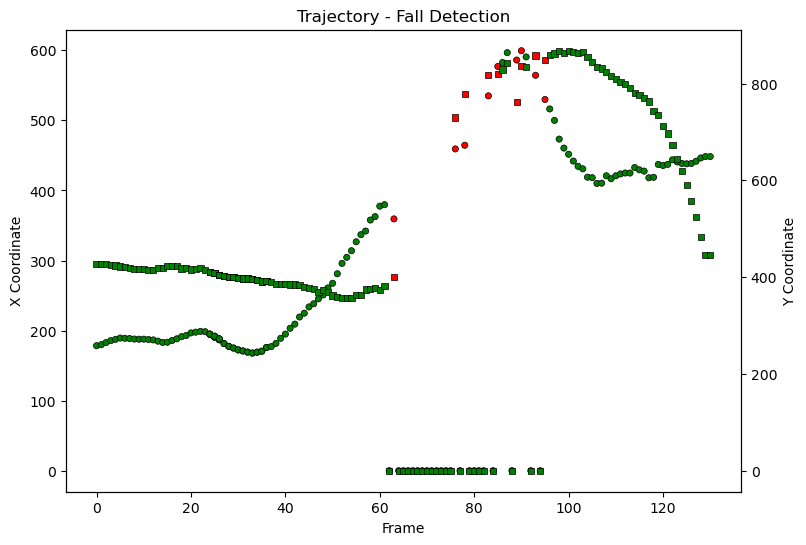

In [41]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load the keypoints data
with open('keypoints_data.json', 'r') as f:
    frame_data = json.load(f)

# Extract the x and y coordinates, frame numbers, and colors
x_coords = []
y_coords = []
frame_numbers = []
x_colors = []
y_colors = []

for event_type in ['fall', 'non_fall']:
    for data in frame_data[event_type]:
        frame_number = data['frame']
        keypoints = data['keypoints']
        x_coord = keypoints[0]  # Assuming keypoints is a list of floats [x, y, ...]
        y_coord = keypoints[1]  # Assuming keypoints is a list of floats [x, y, ...]
        x_coords.append(x_coord)
        y_coords.append(y_coord)
        frame_numbers.append(frame_number)
        if event_type == 'fall':
            x_colors.append('r')
            y_colors.append('r')
        else:
            x_colors.append('g')
            y_colors.append('g')

# Convert lists to numpy arrays
x_coords = np.array(x_coords)
y_coords = np.array(y_coords)
x_colors = np.array(x_colors)
y_colors = np.array(y_colors)
frame_numbers = np.array(frame_numbers)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the x coordinates
ax.scatter(frame_numbers, x_coords, c=x_colors, marker='o', s=20, edgecolors='k', linewidths=0.5)
ax.set_xlabel('Frame')
ax.set_ylabel('X Coordinate')

# Create a twin y-axis for y coordinates
ax2 = ax.twinx()
ax2.scatter(frame_numbers, y_coords, c=y_colors, marker='s', s=20, edgecolors='k', linewidths=0.5)
ax2.set_ylabel('Y Coordinate')

# Set the title
ax.set_title('Trajectory - Fall Detection')

# Adjust the spacing between subplots
plt.subplots_adjust(right=0.8)

plt.show()

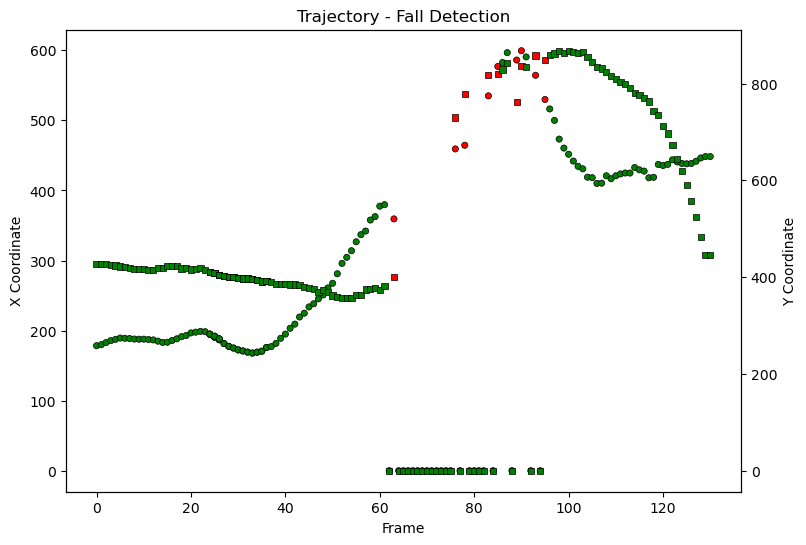

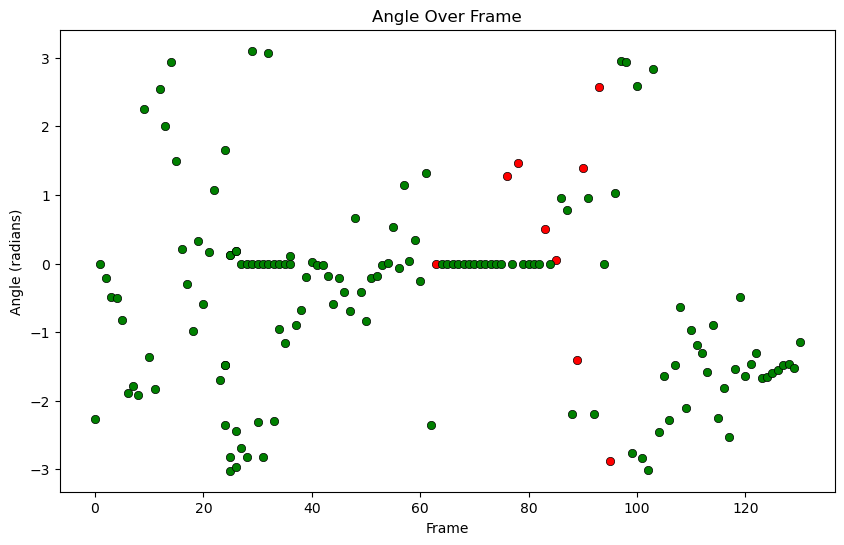

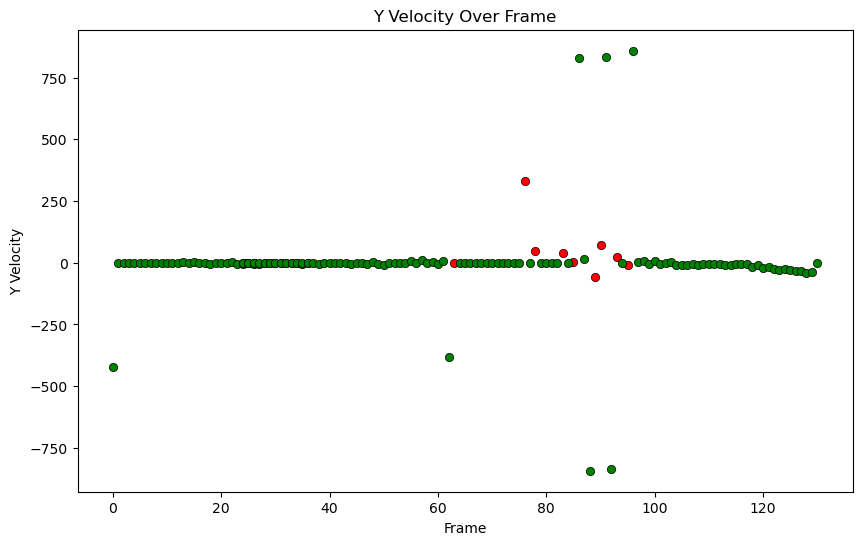

In [45]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load the keypoints data
with open('keypoints_data.json', 'r') as f:
    frame_data = json.load(f)

# Extract the x and y coordinates, frame numbers, and colors
x_coords = []
y_coords = []
frame_numbers = []
x_colors = []
y_colors = []
angle_colors = []
velocity_colors = []

for event_type in ['fall', 'non_fall']:
    for data in frame_data[event_type]:
        frame_number = data['frame']
        keypoints = data['keypoints']
        x_coord = keypoints[0]  # Assuming keypoints is a list of floats [x, y, ...]
        y_coord = keypoints[1]  # Assuming keypoints is a list of floats [x, y, ...]
        x_coords.append(x_coord)
        y_coords.append(y_coord)
        frame_numbers.append(frame_number)
        if event_type == 'fall':
            x_colors.append('r')
            y_colors.append('r')
            angle_colors.append('r')
            velocity_colors.append('r')
        else:
            x_colors.append('g')
            y_colors.append('g')
            angle_colors.append('g')
            velocity_colors.append('g')

# Convert lists to numpy arrays
x_coords = np.array(x_coords)
y_coords = np.array(y_coords)
x_colors = np.array(x_colors)
y_colors = np.array(y_colors)
angle_colors = np.array(angle_colors)
velocity_colors = np.array(velocity_colors)
frame_numbers = np.array(frame_numbers)

# Calculate angles
angles = np.arctan2(np.diff(y_coords), np.diff(x_coords))

# Add a zero angle for the first frame to keep the array length consistent
angles = np.insert(angles, 0, 0)

# Calculate y velocities
y_velocities = np.diff(y_coords)

# Add a zero velocity for the first frame to keep the array length consistent
y_velocities = np.insert(y_velocities, 0, 0)

# Create the plot for coordinates
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the x coordinates
ax.scatter(frame_numbers, x_coords, c=x_colors, marker='o', s=20, edgecolors='k', linewidths=0.5)
ax.set_xlabel('Frame')
ax.set_ylabel('X Coordinate')

# Create a twin y-axis for y coordinates
ax2 = ax.twinx()
ax2.scatter(frame_numbers, y_coords, c=y_colors, marker='s', s=20, edgecolors='k', linewidths=0.5)
ax2.set_ylabel('Y Coordinate')

# Set the title for the coordinates plot
ax.set_title('Trajectory - Fall Detection')

# Adjust the spacing between subplots
plt.subplots_adjust(right=0.8)

# Create a new plot for the angles
fig2, ax3 = plt.subplots(figsize=(10, 6))

# Plot the angles with colors
for i in range(len(frame_numbers)):
    ax3.scatter(frame_numbers[i], angles[i], color=angle_colors[i], marker='o', edgecolors='k', linewidths=0.5)

ax3.set_xlabel('Frame')
ax3.set_ylabel('Angle (radians)')
ax3.set_title('Angle Over Frame')

# Create a new plot for the y velocities
fig3, ax4 = plt.subplots(figsize=(10, 6))

# Plot the y velocities with colors
for i in range(len(frame_numbers)):
    ax4.scatter(frame_numbers[i], y_velocities[i], color=velocity_colors[i], marker='o', edgecolors='k', linewidths=0.5)

ax4.set_xlabel('Frame')
ax4.set_ylabel('Y Velocity')
ax4.set_title('Y Velocity Over Frame')

plt.show()